# 「決定係数」と「ピアソンの積率相関係数の二乗」の関係
* どういうときに一致し，どういうときに一致しないのか，本気で考える．

## この解説のポイント
* **重回帰分析以外では決定係数とピアソンの積率相関係数の二乗は一致しない（ことの方が多い）．**
* **機械学習のモデル作成時に「決定係数の最大化」を利用することは実測値と予測値の誤差を最小化する方向に働くので問題はない．**
* **うっかり「相関係数を最大にする」ようなモデルを作成してしまうと，あまり良いモデルはできない可能性がある．**
* **決定係数が低く算出されるケースでも，ピアソンの積率相関係数の二乗は高く算出されることがあるので，しっかり使い分けましょう．**

## 主な計算用関数
* Python
    * 決定係数：sklearn.metrics.r2_score
    * ピアソンの積率相関係数：numpy.corrcoef
* エクセル
    * 決定係数：？（関数が存在しないかも）
    * ピアソンの積率相関係数：correl
* R
    * 決定係数：重回帰分析すると出力される．
    * ピアソンの積率相関係数：cor
<br><br>
※ エクセルとRでは統計解析することを前提としているために，決定係数を直接計算する関数を用意していないのかもしれない．

## 決定係数のおさらい
決定係数は一般的に以下の式で定義される．<br>

$R^2 = \dfrac{\sum_{i=1}^{n} (\hat{y}_i - \bar{y})^2}{\sum_{i=1}^{n} (y_i - \bar{y})^2} \;\;・・・式1  \\
     = 1 - \dfrac{\sum_{i=1}^{n} (y_i - \hat{y})^2}{\sum_{i=1}^{n} (y_i - \bar{y})^2} \;\;・・・式2$

ただし，<br>
* $y_i$ : 目的変数の実測値<br>
* $\hat{y}_i$ : 目的変数の予測値<br>
* $\bar{y}$ : 目的変数の実測値の平均値（＝目的変数の予測値の平均値）<br>
* $n$ : サンプルサイズ

<br>
これを言い換えると以下の通りである．<br>

$R^2 = \dfrac{\mbox{回帰変動平方和}}{全変動平方和} \\
     = 1 - \dfrac{残差変動平方和}{全変動平方和}$

これが，$R^2$が「説明変数により目的変数をどのくらい説明できるかを表す」と言われる所以である．

## ピアソンの積率相関係数（いわゆる「相関係数」）
目的変数の実測値と予測値の相関係数を算出しようとすると，以下のようになる．

$r_{y\hat{y}} = \dfrac{\sum_{i=1}^{n} (y_i - \bar{y})(\hat{y}_i - \bar{y})} {\sqrt{\sum_{i=1}^{n} (y_i - \bar{y})^2}\sqrt{\sum_{i=1}^{n} (\hat{y}_i - \bar{y})^2} }$

ただし，<br>
* $y_i$ : 目的変数の実測値<br>
* $\hat{y}_i$ : 目的変数の予測値<br>
* $\bar{y}$ : 目的変数の実測値の平均値（＝目的変数の予測値の平均値）<br>
* $n$ : サンプルサイズ<br>

これを言い換えると以下の通りである．

$r_{y\hat{y}} = \dfrac{s_{y\hat{y}}}{s_ys_\hat{y}}$

ただし，
* $s_{y\hat{y}}$ : 実測値と予測値の共分散
* $s_y$ : 実測値の標準偏差
* $s_\hat{y}$ : 予測値の標準偏差



## 決定係数＝相関係数の二乗となる証明
* [証明はここ](https://mathtrain.jp/ketteikeisu)
* この証明では決定係数の式1から相関係数の式が導出できることを証明している
* この証明が成り立つ前提条件
    * 予測値と実測値の平均が一致すること
    * 線形回帰モデルであること

## 問題意識
* 機械学習を扱っていると，$R^2$が負になることがある．式1は必ず＞0となるはずなのに何で？そもそも式1と式2の等式が成り立っていない？
* scikit-learnの`r2_score`関数は式2を使っている．

## 現象論的に確認してみる

### 相関係数・決定係数の定義

In [1]:
import numpy as np
# 相関係数と決定係数の定義に基づきちゃんと実装してみる
# 決定係数については予測値の平均値と実測値の平均値が一致する前提での実装．
def calc_corcoef(yt, yp):
    s_yt = np.sqrt(np.sum((yt - yt.mean())**2))
    s_yp = np.sqrt(np.sum((yp - yp.mean())**2))
    s_ytyp = (yt - yt.mean()).dot(yp - yp.mean())
    r_ytyp = s_ytyp / (s_yt * s_yp)
    return r_ytyp

def calc_detcoef1(yt, yp):
    detcoef1 = np.sum((yp - yt.mean())**2) / np.sum((yt - yt.mean())**2)
    return detcoef1

def calc_detcoef2(yt, yp):
    detcoef2 = 1 - np.sum((yt - yp)**2) / np.sum((yt - yt.mean())**2)
    return detcoef2

### サンプルデータで確認
* 以下ではピアソンの積率相関係数の二乗と決定係数を以下のように使い分ける
    * $r^2$ : ピアソンの積率相関係数の二乗
    * $R^2_{f1}$ : 式1から導出した決定係数
    * $R^2_{f2}$ : 式2から導出した決定係数
    * $R^2_{sklearn}$ : scikit-learnの`r2_score`関数で出力した決定係数

In [2]:
import os
if not os.path.exists("img"): os.mkdir("img")

#### CASE1: 線形回帰モデル・全サンプルを学習

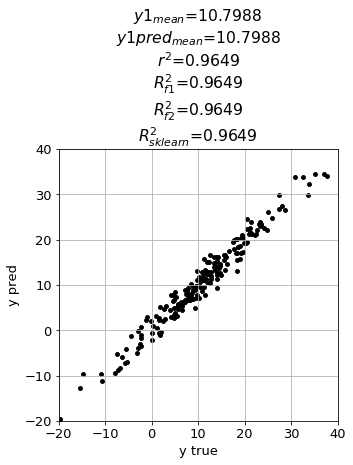

In [3]:
import numpy as np
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

#正規分布に従う乱数生成
np.random.seed(10)
x1 = np.random.normal(loc=5, scale=5, size=200) # 平均5・標準偏差5となる正規分布に従うサンプルを200個生成
noise = np.random.normal(loc=0, scale=2, size=200) # 標準正規分布に従うノイズサンプルを200個生成
y1 = 2 * x1 + noise

model_all = LinearRegression()
model_all.fit(x1.reshape(-1,1), y1.reshape(-1,1))
y1_pred = model_all.predict(x1.reshape(-1,1)).flatten()

corcoef = calc_corcoef(y1, y1_pred)
detcoef1 = calc_detcoef1(y1, y1_pred)
detcoef2 = calc_detcoef2(y1, y1_pred)
r2score = r2_score(y1, y1_pred)

title = "$y1_{mean}$=" + str(round(y1.mean(),4)) + "\n" + \
        "$y1pred_{mean}$=" + str(round(y1_pred.mean(),4)) + "\n" + \
        "$r^2$=" + str(round(corcoef**2,4)) + "\n" + \
        "$R^2_{f1}$=" + str(round(detcoef1,4)) + "\n" + \
        "$R^2_{f2}$=" + str(round(detcoef2,4)) + "\n" + \
        "$R^2_{sklearn}$=" + str(round(r2score,4))

plt.rcParams['font.size']=13
plt.figure(figsize=(5,5))
plt.title(title)
plt.scatter(y1, y1_pred, c='k', s=15)
plt.xlabel('y true')
plt.ylabel('y pred')
plt.xlim(-20,40)
plt.ylim(-20,40)
plt.grid()
plt.savefig("img/決定係数_case1.png", bbox_inches="tight")
plt.show()

#### CASE2: 線形回帰モデル・何かの拍子にy1_pred = 0.7*y1_predとなったら？ 

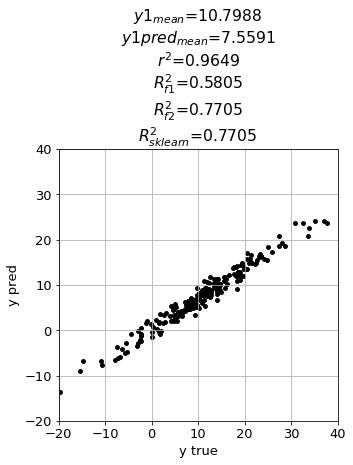

In [4]:
import numpy as np
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

#正規分布に従う乱数生成
np.random.seed(10)
x1 = np.random.normal(loc=5, scale=5, size=200) # 平均5・標準偏差5となる正規分布に従うサンプルを200個生成
noise = np.random.normal(loc=0, scale=2, size=200) # 標準正規分布に従うノイズサンプルを200個生成
y1 = 2 * x1 + noise

model_all = LinearRegression()
model_all.fit(x1.reshape(-1,1), y1.reshape(-1,1))
y1_pred = model_all.predict(x1.reshape(-1,1)).flatten()

y1_pred = 0.7 * y1_pred

corcoef = calc_corcoef(y1, y1_pred)
detcoef1 = calc_detcoef1(y1, y1_pred)
detcoef2 = calc_detcoef2(y1, y1_pred)
r2score = r2_score(y1, y1_pred)

title = "$y1_{mean}$=" + str(round(y1.mean(),4)) + "\n" + \
        "$y1pred_{mean}$=" + str(round(y1_pred.mean(),4)) + "\n" + \
        "$r^2$=" + str(round(corcoef**2,4)) + "\n" + \
        "$R^2_{f1}$=" + str(round(detcoef1,4)) + "\n" + \
        "$R^2_{f2}$=" + str(round(detcoef2,4)) + "\n" + \
        "$R^2_{sklearn}$=" + str(round(r2score,4))

plt.rcParams['font.size']=13
plt.figure(figsize=(5,5))
plt.title(title)
plt.scatter(y1, y1_pred, c='k', s=15)
plt.xlabel('y true')
plt.ylabel('y pred')
plt.xlim(-20,40)
plt.ylim(-20,40)
plt.grid()
plt.savefig("img/決定係数_case2.png", bbox_inches="tight")
plt.show()

#### CASE3: 線形回帰モデル・クロスバリデーション

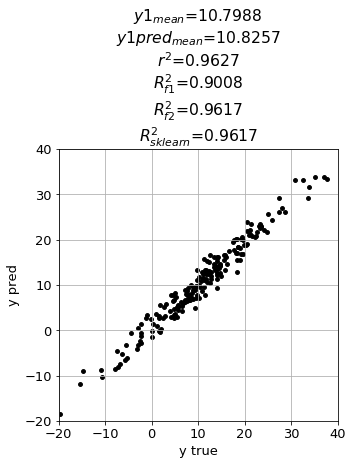

In [5]:
import numpy as np
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, cross_val_predict
from sklearn.pipeline import Pipeline

#正規分布に従う乱数生成
np.random.seed(10)
x1 = np.random.normal(loc=5, scale=5, size=200) # 平均5・標準偏差5となる正規分布に従うサンプルを200個生成
noise = np.random.normal(loc=0, scale=2, size=200) # 標準正規分布に従うノイズサンプルを200個生成
y1 = 2 * x1 + noise

x1 = x1[y1.argsort()]
y1 = y1[y1.argsort()]

model_all = LinearRegression()
cv = KFold(n_splits=5, shuffle=False)
y1_pred_cv = cross_val_predict(model_all, x1.reshape(-1,1), y1.reshape(-1,1), cv=cv).flatten()


corcoef = calc_corcoef(y1, y1_pred_cv)
detcoef1 = calc_detcoef1(y1, y1_pred_cv)
detcoef2 = calc_detcoef2(y1, y1_pred_cv)
r2score = r2_score(y1, y1_pred_cv)
title = "$y1_{mean}$=" + str(round(y1.mean(),4)) + "\n" + \
        "$y1pred_{mean}$=" + str(round(y1_pred_cv.mean(),4)) + "\n" + \
        "$r^2$=" + str(round(corcoef**2,4)) + "\n" + \
        "$R^2_{f1}$=" + str(round(detcoef1,4)) + "\n" + \
        "$R^2_{f2}$=" + str(round(detcoef2,4)) + "\n" + \
        "$R^2_{sklearn}$=" + str(round(r2score,4))

plt.rcParams['font.size']=13
plt.figure(figsize=(5,5))
plt.title(title)
plt.scatter(y1, y1_pred_cv, c='k', s=15)
plt.xlabel('y true')
plt.ylabel('y pred')
plt.xlim(-20,40)
plt.ylim(-20,40)
plt.grid()
plt.savefig("img/決定係数_case3.png", bbox_inches="tight")
plt.show()

#### CASE1 vs CASE2

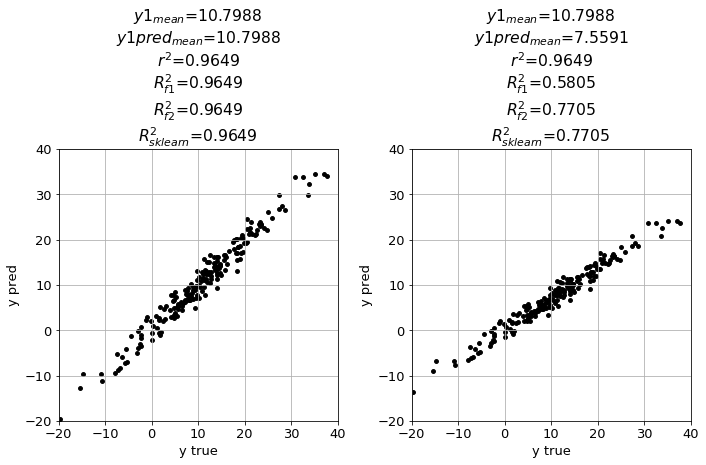

In [6]:
from PIL import Image

im1 = Image.open("img/決定係数_case1.png")
im2 = Image.open("img/決定係数_case2.png")
dst = Image.new('RGB', (im1.width + im2.width, im1.height))
dst.paste(im1, (0, 0))
dst.paste(im2, (im1.width, 0))
dst

* 左図はCASE1の結果，右図はCASE2の結果．
    * CASE1では実測値と予測値の平均が等しいが，CASE2では実測値と予測値の平均が等しくなくなった．
    * 決定係数はCASE1よりもCASE2で小さくなった．
    * CASE2では$R^2_{f1}$と$R^2_{f2}$が一致しなかった．
    * $r^2$はCASE1とCASE2で一致した．

#### CASE1 vs CASE3

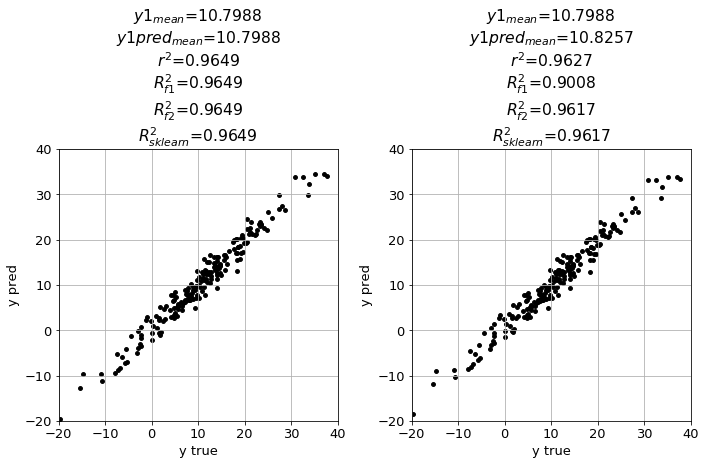

In [7]:
from PIL import Image

im1 = Image.open("img/決定係数_case1.png")
im2 = Image.open("img/決定係数_case3.png")
dst = Image.new('RGB', (im1.width + im2.width, im1.height))
dst.paste(im1, (0, 0))
dst.paste(im2, (im1.width, 0))
dst

#### CASE4: 非線形回帰モデル・全サンプルを学習

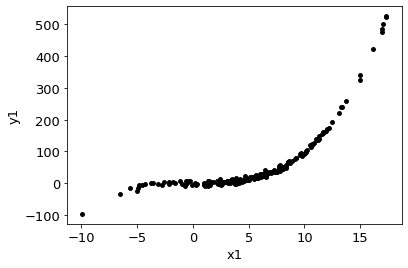

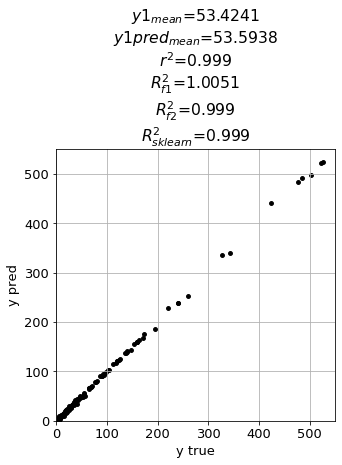

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor

#正規分布に従う乱数生成
np.random.seed(10)
x1 = np.random.normal(loc=5, scale=5, size=200) # 平均5・標準偏差5となる正規分布に従うサンプルを200個生成
noise = np.random.normal(loc=0, scale=5, size=200) # 平均0・標準偏差5となる正規分布に従うノイズサンプルを200個生成
y1 = x1**2 * 0.1*x1 + noise

plt.rcParams['font.size']=13
plt.scatter(x1, y1, c='k', s=15)
plt.xlabel('x1')
plt.ylabel('y1')
plt.show()

model_all = RandomForestRegressor(random_state=0)
model_all.fit(x1.reshape(-1,1), y1)
y1_pred = model_all.predict(x1.reshape(-1,1)).flatten()


corcoef = calc_corcoef(y1, y1_pred)
detcoef1 = calc_detcoef1(y1, y1_pred)
detcoef2 = calc_detcoef2(y1, y1_pred)
r2score = r2_score(y1, y1_pred)

title = "$y1_{mean}$=" + str(round(y1.mean(),4)) + "\n" + \
        "$y1pred_{mean}$=" + str(round(y1_pred.mean(),4)) + "\n" + \
        "$r^2$=" + str(round(corcoef**2,4)) + "\n" + \
        "$R^2_{f1}$=" + str(round(detcoef1,4)) + "\n" + \
        "$R^2_{f2}$=" + str(round(detcoef2,4)) + "\n" + \
        "$R^2_{sklearn}$=" + str(round(r2score,4))

plt.rcParams['font.size']=13
plt.figure(figsize=(5,5))
plt.title(title)
plt.scatter(y1, y1_pred, c='k', s=15)
plt.xlabel('y true')
plt.ylabel('y pred')
plt.xlim(0,550)
plt.ylim(0,550)
plt.grid()
plt.savefig("img/決定係数_case4.png", bbox_inches="tight")
plt.show()

#### CASE5: 非線形回帰モデル・クロスバリデーション

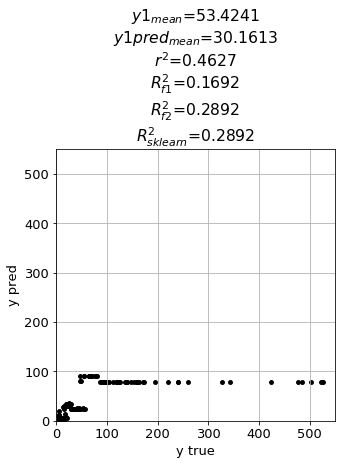

In [21]:
import numpy as np
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, cross_val_predict

#正規分布に従う乱数生成
np.random.seed(10)
x1 = np.random.normal(loc=5, scale=5, size=200) # 平均5・標準偏差5となる正規分布に従うサンプルを200個生成
noise = np.random.normal(loc=0, scale=5, size=200) # 平均0・標準偏差5となる正規分布に従うノイズサンプルを200個生成
y1 = x1**2 * 0.1*x1 + noise

# CV時の予測性能が「悪く」なるようにデータを並び替え
x1 = x1[y1.argsort()]
y1 = y1[y1.argsort()]

model_all = RandomForestRegressor(random_state=0)
cv = KFold(n_splits=5, shuffle=False)
y1_pred_cv = cross_val_predict(model_all, x1.reshape(-1,1), y1, cv=cv).flatten()


corcoef = calc_corcoef(y1, y1_pred_cv)
detcoef1 = calc_detcoef1(y1, y1_pred_cv)
detcoef2 = calc_detcoef2(y1, y1_pred_cv)
r2score = r2_score(y1, y1_pred_cv)
title = "$y1_{mean}$=" + str(round(y1.mean(),4)) + "\n" + \
        "$y1pred_{mean}$=" + str(round(y1_pred_cv.mean(),4)) + "\n" + \
        "$r^2$=" + str(round(corcoef**2,4)) + "\n" + \
        "$R^2_{f1}$=" + str(round(detcoef1,4)) + "\n" + \
        "$R^2_{f2}$=" + str(round(detcoef2,4)) + "\n" + \
        "$R^2_{sklearn}$=" + str(round(r2score,4))

plt.rcParams['font.size']=13
plt.figure(figsize=(5,5))
plt.title(title)
plt.scatter(y1, y1_pred_cv, c='k', s=15)
plt.xlabel('y true')
plt.ylabel('y pred')
plt.xlim(0,550)
plt.ylim(0,550)
plt.grid()
plt.savefig("img/決定係数_case5.png", bbox_inches="tight")
plt.show()

#### CASE4 vs CASE5

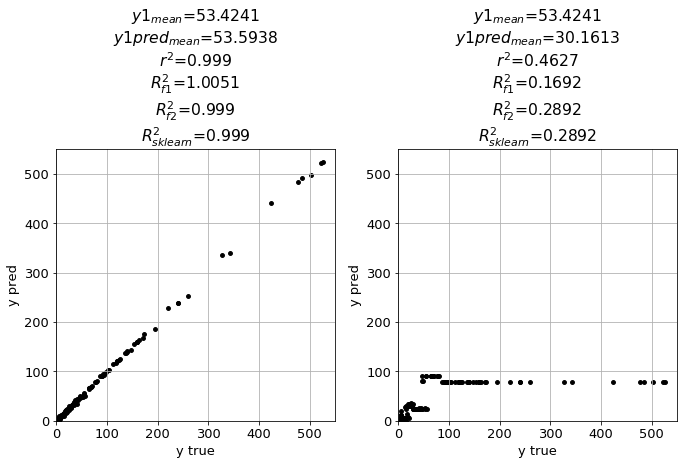

In [22]:
from PIL import Image

im1 = Image.open("img/決定係数_case4.png")
im2 = Image.open("img/決定係数_case5.png")
dst = Image.new('RGB', (im1.width + im2.width, im1.height))
dst.paste(im1, (0, 0))
dst.paste(im2, (im1.width, 0))
dst

* 左図はCASE4の結果，右図はCASE5の結果．
    * CASE4では実測値と予測値の平均が若干異なった．
        * 非線形モデルでは全サンプルをフィットした予測値の平均値が実測値の平均値と一致しない．
    * CASE4，CASE5ともに$R^2_{f1}$と$R^2_{f2}$が一致しなかった．
    * CASE5では決定係数が小さかったが，$r^2$で見るとそこそこの大きさであった．

## 決定係数を正しく導出するためには？

全変動平方和の式に立ち戻る．

[全変動平方和]<br>
$= \sum_{i=1}^{n} (y_i - \bar{y})^2 = \sum_{i=1}^{n} \{(y_i-\hat{y}_i) + (\hat{y}_i-\bar{y}) \}^2 \\
= \sum_{i=1}^{n} (y_i - \hat{y}_i)^2 + \sum_{i=1}^{n} (\hat{y}_i - \bar{y})^2 + 2\sum_{i=1}^{n} (y_i - \hat{y}_i)(\hat{y}_i - \bar{y})$ 

= [残差変動平方和] + [回帰変動平方和] + [その他]<br>

重回帰分析では上記の **[その他]＝0** となるため，<br>
**[全変動平方和] = [残差変動平方和] + [回帰変動平方和]**<br>
が成り立ち，したがい，冒頭の「決定係数のおさらい」の式1＝式2が成立する．<br>

それでは，CASE1~5における[その他]項を計算するとどうなるか？


In [14]:
def calc_other(yt, yp):
    val = 2 * np.sum((yt - yp)*(yp - yt.mean()))
    return round(val,7)

In [24]:
import numpy as np
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

#正規分布に従う乱数生成
np.random.seed(10)
x1 = np.random.normal(loc=5, scale=5, size=200) # 平均5・標準偏差5となる正規分布に従うサンプルを200個生成
noise = np.random.normal(loc=0, scale=2, size=200) # 標準正規分布に従うノイズサンプルを200個生成
y1 = 2 * x1 + noise

model_all = LinearRegression()
model_all.fit(x1.reshape(-1,1), y1.reshape(-1,1))
y1_pred = model_all.predict(x1.reshape(-1,1)).flatten()

# CASE 1
val_other = calc_other(y1, y1_pred)
print("CASE1: ", val_other)

# CASE 2
y1_pred = 0.7 * y1_pred
val_other = calc_other(y1, y1_pred)
print("CASE2: ", val_other)

# CASE3
x1 = x1[y1.argsort()]
y1 = y1[y1.argsort()]
model_all = LinearRegression()
cv = KFold(n_splits=5, shuffle=False)
y1_pred_cv = cross_val_predict(model_all, x1.reshape(-1,1), y1.reshape(-1,1), cv=cv).flatten()
val_other = calc_other(y1, y1_pred_cv)
print("CASE3: ", val_other)

# CASE 4
#正規分布に従う乱数生成
np.random.seed(10)
x1 = np.random.normal(loc=5, scale=5, size=200) # 平均5・標準偏差5となる正規分布に従うサンプルを200個生成
noise = np.random.normal(loc=0, scale=5, size=200) # 平均0・標準偏差5となる正規分布に従うノイズサンプルを200個生成
y1 = x1**2 * 0.1*x1 + noise

model_all = RandomForestRegressor(random_state=0)
model_all.fit(x1.reshape(-1,1), y1)
y1_pred = model_all.predict(x1.reshape(-1,1)).flatten()
val_other = calc_other(y1, y1_pred)
print("CASE4: ", val_other)

# CASE 5
# CV時の予測性能が「悪く」なるようにデータを並び替え
x1 = x1[y1.argsort()]
y1 = y1[y1.argsort()]

model_all = RandomForestRegressor(random_state=0)
cv = KFold(n_splits=5, shuffle=False)
y1_pred_cv = cross_val_predict(model_all, x1.reshape(-1,1), y1, cv=cv).flatten()
val_other = calc_other(y1, y1_pred_cv)
print("CASE5: ", val_other)

CASE1:  -0.0
CASE2:  3704.5761411
CASE3:  1187.2584989
CASE4:  -11944.2491515
CASE5:  233336.7944257


はい，CASE1以外，**[その他] 項が0にならない**ことを確認できた．<br>
したがって，**[その他] 項**で補正することで決定係数をただしく算出することができるかもしれないが，<br>
これはそもそも従来の決定係数の意味と合致した指標として捉えて良いのか，もう少し考察が必要．

## 所感
* そもそも決定係数はすべてのデータをあてはめた線形モデルの説明力を評価するために用いられてきた指標である．
* 深く考えずにR2cvが高くなるようにモデル構築しても問題ないと思うが，決定係数の導出背景を理解し「ピアソンの積率相関係数の二乗」とは区別する必要がある．
* 重回帰分析では，説明変数の数が多くなるほど決定係数は大きくなるので，そのままでは説明変数の数が異なるモデル間での性能比較はできない．原則，[自由度調整済み決定係数](https://bellcurve.jp/statistics/course/9706.html)で比較する．

## 参考URL・書籍
* [統計学の時間](https://bellcurve.jp/statistics/course/9706.html)
* 『日本統計学会公式認定　統計検定2級対応　統計学基礎』，日本統計学会